Some updates made to prior notebooks:

* Removed validation leakage from agg functions on time_id. This had the effect of making many features redundant (that were previously thought to be important)
* Stratified GroupKFold introduced. We only want new time id's in the validation sets (because this will be the case when forecasting) and it seems all stocks will be in the forecast so it is best that we learn sufficiently from every stock (hence the stratified part).
* Introduced some new features (research on arxiv and Google Scholar). You will note many unused functions below for you to play around with. There are also unused functions to try out various other sampling techniques. Enjoy!

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import lightgbm as lgb

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    """ https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation """
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in tqdm(sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])), total=len(groups_and_y_counts)):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [3]:
def read_train_test():
    # Function to read our base train and test set
    
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    print(f'Our test set has {test.shape[0]} rows')
    print(f'Our training set has {train.isna().sum().sum()} missing values')
    print(f'Our test set has {test.isna().sum().sum()} missing values')
    
    return train, test

train, test = read_train_test()

Our training set has 428932 rows
Our test set has 3 rows
Our training set has 0 missing values
Our test set has 0 missing values


In [4]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to aggregate 1st and 2nd WAP
def calc_wap12(df):
    var1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    var2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    den = df['bid_size1'] + df['ask_size1'] + df['bid_size2'] + df['ask_size2']
    return (var1+var2) / den

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap34(df):
    var1 = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']
    var2 = df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']
    den = df['bid_size1'] + df['ask_size1'] + df['bid_size2'] + df['ask_size2']
    return (var1+var2) / den

def calc_swap12(df):
    return df['wap12'] - df['wap34']

def calc_tswap1(df):
    return -df['swap1'].diff()

def calc_tswap12(df):
    return -df['swap12'].diff()

def calc_wss12(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (ask - bid) / df['midprice']

# Calculate order book depth
def calc_depth(df):
    depth = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1'] + df['bid_price2'] * df[
               'bid_size2'] + df['ask_price2'] * df['ask_size2']
    return depth

# Calculate order book slope
def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)

# Calculate order book dispersion
def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']

#  order flow imbalance
def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

# Turnover
def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

# Function to calculate the log of the return
def log_return(series):
    return np.log(series).diff()

def log_return_out(series):
    ret = np.log(series).diff()
    return remove_outliers(ret)

def remove_outliers(series):
    cu = 6
    ser_mean, ser_std = np.mean(series), np.std(series)
    series = series.where(series<=(ser_mean + cu*ser_std), ser_mean)
    series = series.where(series>=(ser_mean - cu*ser_std), ser_mean)
    return series

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))
    
def realized_volatility_downside(series):
    return np.sqrt(np.sum(series[series<0]**2))

def realized_volatility_upside(series):
    return np.sqrt(np.sum(series[series>0]**2))

# realized bipower variation 
def realized_bipowvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/2)*(cnt/(cnt-2))
        return cons*np.nansum(np.abs(series)*np.abs(series.shift()))
    
# Calculate integrated quarticity
def realized_quarticity(series):
    return (series.count()/3)*np.sum(series**4)

# realized median variation 
def realized_medianvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/(6-4*np.sqrt(3)+np.pi))*(cnt/(cnt-2))
        return cons*np.nansum(np.median([np.abs(series),np.abs(series.shift()),np.abs(series.shift(2))], axis=0)**2)
    
# Calculate the realized absolute variatian
def realized_absvar(series):
    return np.sqrt(np.pi/(2*series.count()))*np.sum(np.abs(series))

# Calculate weighted volatility
def realized_vol_weighted(series):
    return np.sqrt(np.sum(series**2)/series.count())

# Calculate the realized skew
def realized_skew(series):
    return np.sqrt(series.count())*np.sum(series**3)/(realized_volatility(series)**3)

# Calculate the realized kurtosis
def realized_kurtosis(series):
    return series.count()*np.sum(series**4)/(realized_volatility(series)**4)

# Function to get group stats for different windows (seconds in bucket)
def get_stats_bins(df, feat_dict, bins, quantile=False):
    # Group by the window
    if bins==0:
        df_feature = df.groupby('time_id').agg(feat_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        df_feature = df_feature.rename(columns={'time_id_': 'time_id'})
    else:
        if quantile:
            df['sbins'] = pd.qcut(df.seconds_in_bucket, bins, labels=False)
            q = 'q'
        else:
            df['sbins'] = pd.cut(df.seconds_in_bucket, bins, labels=False)
            q = ''
        df_feature = None
        for i in range(bins):
            df_feat = df.loc[df.sbins==i].groupby('time_id').agg(feat_dict).reset_index()
            # Rename columns joining suffix
            df_feat.columns = ['_'.join(col) for col in df_feat.columns]
            # Add a suffix to differentiate bins
            df_feat = df_feat.rename(columns={col: col+'_'+q+str(bins)+'bins_'+str(i) for col in df_feat.columns})
            df_feat = df_feat.rename(columns={'time_id_'+'_'+q+str(bins)+'bins_'+str(i): 'time_id'})
            if isinstance(df_feature, pd.DataFrame):
                df_feature = pd.merge(df_feature, df_feat, how='left', on='time_id')
            else:
                df_feature = df_feat.copy()
        df = df.drop('sbins', axis=1)
    return df_feature

# Function to get group stats for different windows (seconds in bucket)
def get_stats_window(df, feat_dict, window):
    # Group by the window
    if window==0:
        df_feature = df.groupby('time_id').agg(feat_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        df_feature = df_feature.rename(columns={'time_id_': 'time_id'})
    else:
        df_feature = None
        for w in range(window, 600, window):
            df_feat = df.loc[df.seconds_in_bucket>=w].groupby('time_id').agg(feat_dict).reset_index()
            # Rename columns joining suffix
            df_feat.columns = ['_'.join(col) for col in df_feat.columns]
            # Add a suffix to differentiate bins
            df_feat = df_feat.rename(columns={col: col+'_'+str(window)+'win_'+str(w) for col in df_feat.columns})
            df_feat = df_feat.rename(columns={'time_id_'+'_'+str(window)+'win_'+str(w): 'time_id'})
            if isinstance(df_feature, pd.DataFrame):
                df_feature = pd.merge(df_feature, df_feat, how='left', on='time_id')
            else:
                df_feature = df_feat.copy()
    return df_feature

# Function to sample from the window and average
def get_stats_sampled(df, feat_dict, numsamp, fraction, boot):
    df_feature = None
    for i in range(numsamp):
        df_feat = df.groupby('time_id').sample(frac=fraction, random_state=i, replace=boot).reset_index(drop=True)
        df_feat = df_feat.groupby('time_id').agg(feat_dict).reset_index()
        df_feat.columns = ['_'.join(col) for col in df_feat.columns]
        if isinstance(df_feature, pd.DataFrame):
            df_feature += df_feat.values/numsamp   
        else:
            df_feature = df_feat.copy()/numsamp
    df_feature = df_feature.rename(columns={col: col+'_sample_'+str(fraction)+'_'+str(numsamp) for col in df_feature.columns})
    df_feature = df_feature.rename(columns={'time_id_'+'_sample_'+str(fraction)+'_'+str(numsamp): 'time_id'})
    return df_feature

In [5]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    
    #### Data Cleansing (if any needed)
    
    df = df.drop(df.loc[df.ask_price1 <= 0].index)
    df = df.drop(df.loc[df.bid_price1 <= 0].index)
    df = df.drop(df.loc[(df['ask_price1'] - df['bid_price1']) < 0].index)
    df = df.groupby(['time_id','seconds_in_bucket']).mean().reset_index()
    
    ####
    
    # Calculate prices
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    
    df['depth'] = calc_depth(df)
    df['slope'], _ = calc_slope(df)

    # Calculate log returns
    df['log_return1'] = df.groupby('time_id')['wap1'].apply(log_return)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    # Calculate spreads
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['dispersion'], _ = calc_dispersion(df)

    # Dict for aggregations
    create_feature_dict = {
        'depth': [np.sum],
        'slope': [np.sum],
        'log_return1': [realized_volatility, realized_absvar],
        'log_return2': [realized_volatility, realized_absvar],
        'price_spread': [np.sum, np.nanmedian],
    }

    create_feature_dict_bins = {
        'depth': [np.sum],
        'slope': [np.sum],
        'dispersion': [np.sum],
        'log_return1': [realized_volatility, realized_absvar],
        'log_return2': [realized_volatility, realized_absvar],
        'price_spread': [np.sum],
    }


    # Get the stats for different windows
    df_feature_0 = get_stats_bins(df, create_feature_dict, 0)
    df_feature_w4 = get_stats_window(df, create_feature_dict_bins, 150)

    # Merge all
    df_feature_0 = df_feature_0.merge(df_feature_w4, how = 'left', on = 'time_id')   

    df_feature_0 = df_feature_0.add_prefix('book_')
    stock_id = file_path.split('=')[1]
    df_feature_0['row_id'] = df_feature_0['book_time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_feature_0.drop(['book_time_id'], axis = 1, inplace = True)
    return df_feature_0

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)

    #### Data Cleansing
    
    df = df.drop(df.loc[df.price <= 0].index)
    df = df.groupby(['time_id','seconds_in_bucket']).mean().reset_index()
    
    ####
    
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return': [realized_volatility, realized_absvar],
        'order_count':[np.sum, np.max],
    }
    
    create_feature_dict_bins = {
        'log_return': [realized_volatility, realized_absvar],
        'order_count': [np.sum],
    }
    
    # Get the stats for different windows
    df_feature_0 = get_stats_bins(df, create_feature_dict, 0)
    df_feature_w4 = get_stats_window(df, create_feature_dict_bins, 150)

    # Merge all
    df_feature_0 = df_feature_0.merge(df_feature_w4, how = 'left', on = 'time_id')   

    df_feature_0 = df_feature_0.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature_0['row_id'] = df_feature_0['trade_time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_feature_0.drop(['trade_time_id'], axis = 1, inplace = True)
    return df_feature_0
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')      
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')
gc.collect()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 31.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


410

In [6]:
train['trade_size_tau'] = np.sqrt(1/train['trade_order_count_sum'])
    
for w in range(150, 600, 150):
    train['trade_size_tau_150win_'+str(w)] = np.sqrt(1/train['trade_order_count_sum_150win_'+str(w)])

In [7]:
test['trade_size_tau'] = np.sqrt(1/test['trade_order_count_sum'])
    
for w in range(150, 600, 150):
    test['trade_size_tau_150win_'+str(w)] = np.sqrt(1/test['trade_order_count_sum_150win_'+str(w)])

In [8]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# Function to get group stats for the stock_id and time_id
def get_time_agg(df):
    gcols=['book_log_return1_realized_volatility']
    gcols+=['book_log_return1_realized_volatility_150win_150']
    gcols+=['book_log_return2_realized_volatility_150win_300']
    gcols+=['book_log_return1_realized_volatility_150win_450']+['trade_log_return_realized_volatility_150win_450']
    gcols+=['book_price_spread_sum_150win_150']
    gcols+=['trade_size_tau_150win_150']
    gcols+=['book_depth_sum_150win_150']
    gcols+=['book_dispersion_sum_150win_150']

    # Group by the stock id
    df_time_id = df.groupby('time_id')[gcols].agg(['mean', 'std', 'max', 'min']).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df_time_id = df_time_id.rename(columns={'time_id__time':'time_id'})
    return df_time_id, [col for col in df_time_id if col not in ['time_id']]

In [9]:
cols = ['row_id','time_id','stock_id','target']
cols+=['book_log_return1_realized_volatility']
cols+=['book_log_return1_realized_volatility_150win_150']+['book_log_return2_realized_volatility_150win_150']+[
            'trade_log_return_realized_volatility_150win_150']
cols+=['book_log_return1_realized_absvar_150win_150']+['book_log_return2_realized_absvar_150win_150']+[
            'trade_log_return_realized_absvar_150win_150']
cols+=['book_log_return2_realized_volatility_150win_300']
cols+=['book_log_return1_realized_volatility_150win_450']+['trade_log_return_realized_volatility_150win_450']
cols+=['book_price_spread_sum_150win_150']
cols+=['trade_size_tau_150win_150']
cols+=['book_depth_sum_150win_150']
cols+=['book_dispersion_sum_150win_150']

train = train[[col for col in train.columns if col in cols]]
test = test[[col for col in test.columns if col in cols]]

100%|██████████| 3830/3830 [02:10<00:00, 29.30it/s]


Training fold 1
(343146, 18)
(85786, 18)
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000469997	training's RMSPE: 0.217394	valid_1's rmse: 0.000485219	valid_1's RMSPE: 0.225085
[100]	training's rmse: 0.000454895	training's RMSPE: 0.210409	valid_1's rmse: 0.000478178	valid_1's RMSPE: 0.221819
[150]	training's rmse: 0.000445541	training's RMSPE: 0.206082	valid_1's rmse: 0.000475328	valid_1's RMSPE: 0.220497
[200]	training's rmse: 0.000438426	training's RMSPE: 0.202792	valid_1's rmse: 0.000473662	valid_1's RMSPE: 0.219724
[250]	training's rmse: 0.00043237	training's RMSPE: 0.19999	valid_1's rmse: 0.000473299	valid_1's RMSPE: 0.219556
[300]	training's rmse: 0.000427304	training's RMSPE: 0.197647	valid_1's rmse: 0.000472439	valid_1's RMSPE: 0.219157
[350]	training's rmse: 0.000422518	training's RMSPE: 0.195433	valid_1's rmse: 0.000472279	valid_1's RMSPE: 0.219083
[400]	training's rmse: 0.000418881	training's RMSPE: 0.193751	valid_1's rmse: 0.000472019

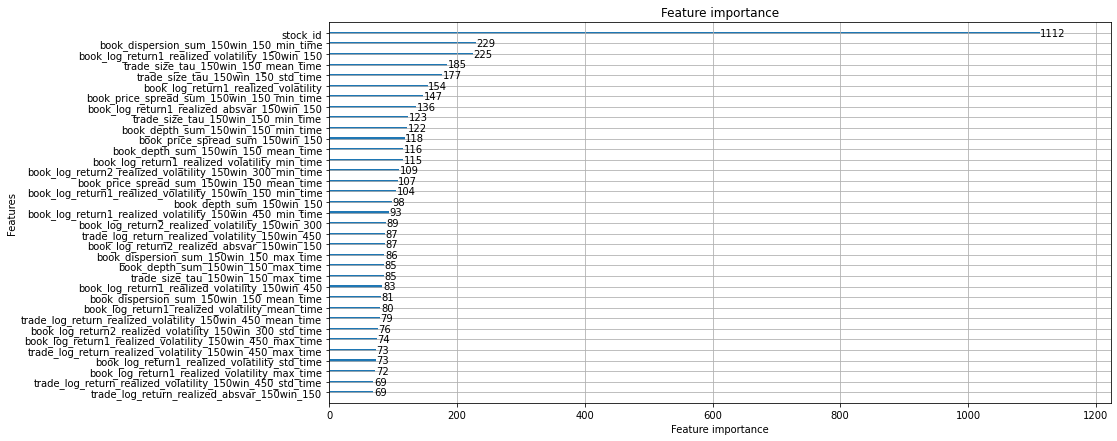

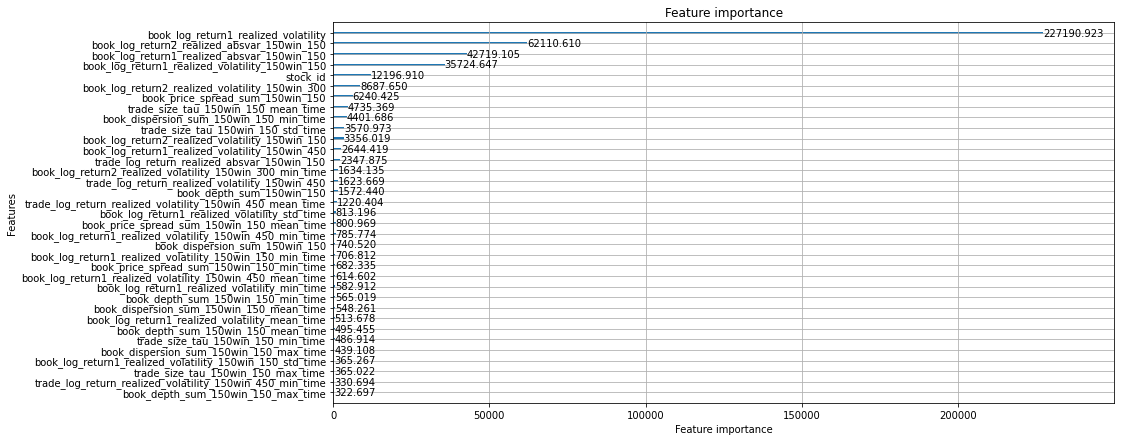

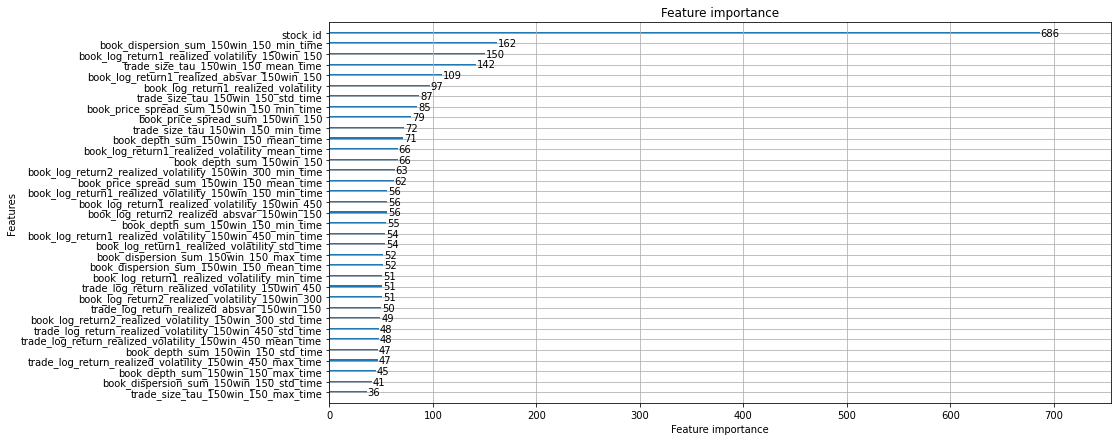

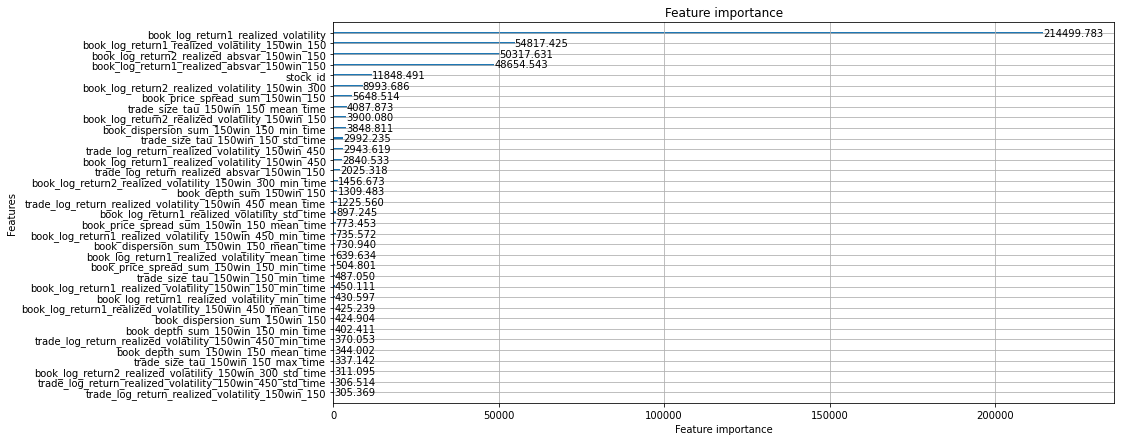

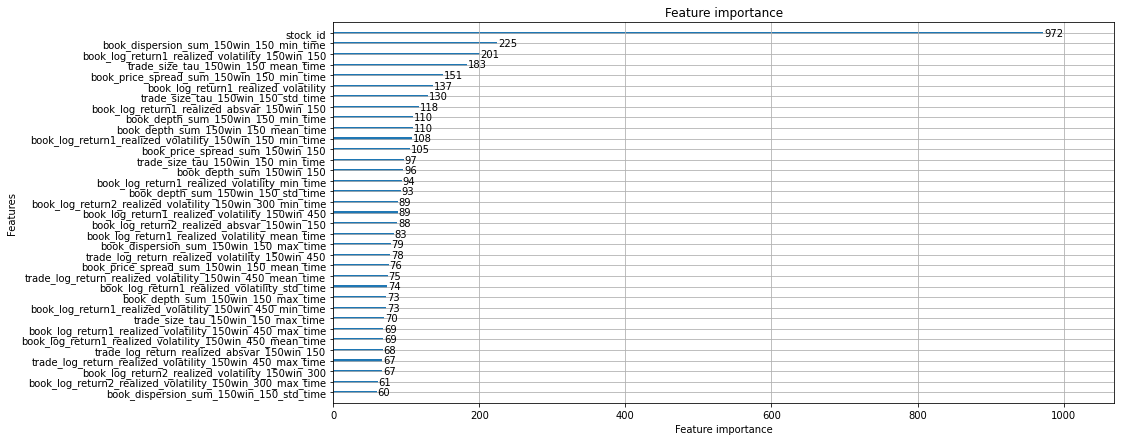

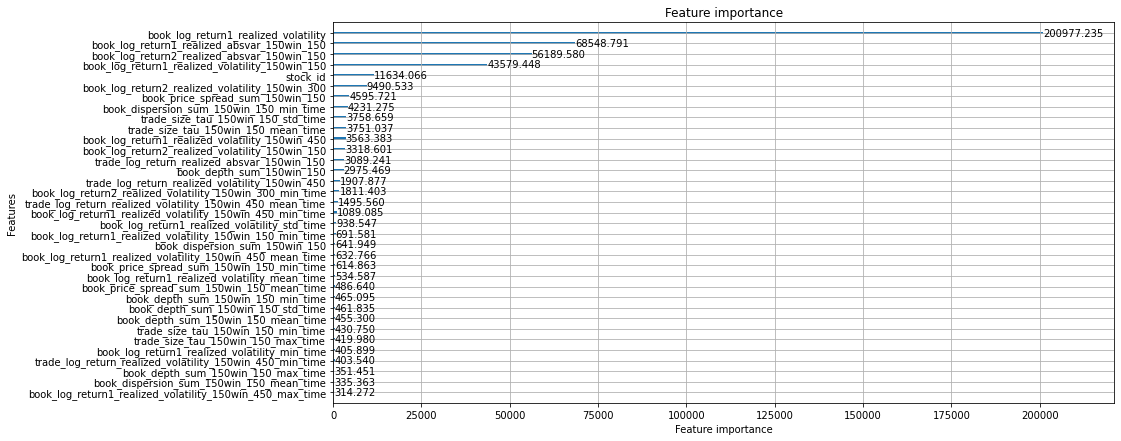

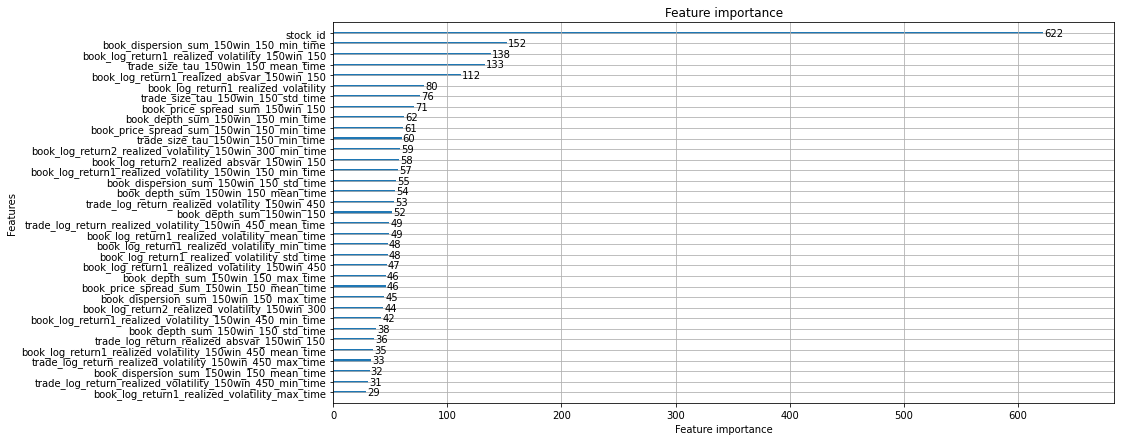

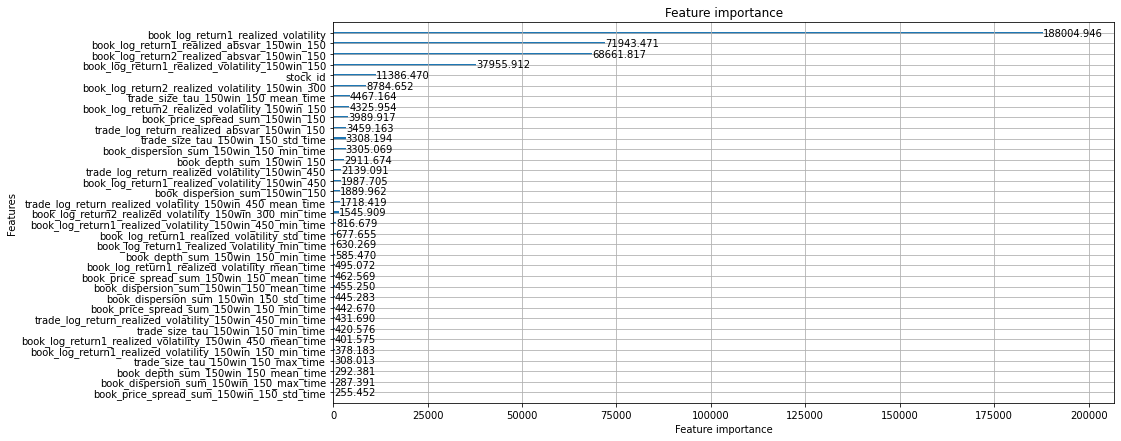

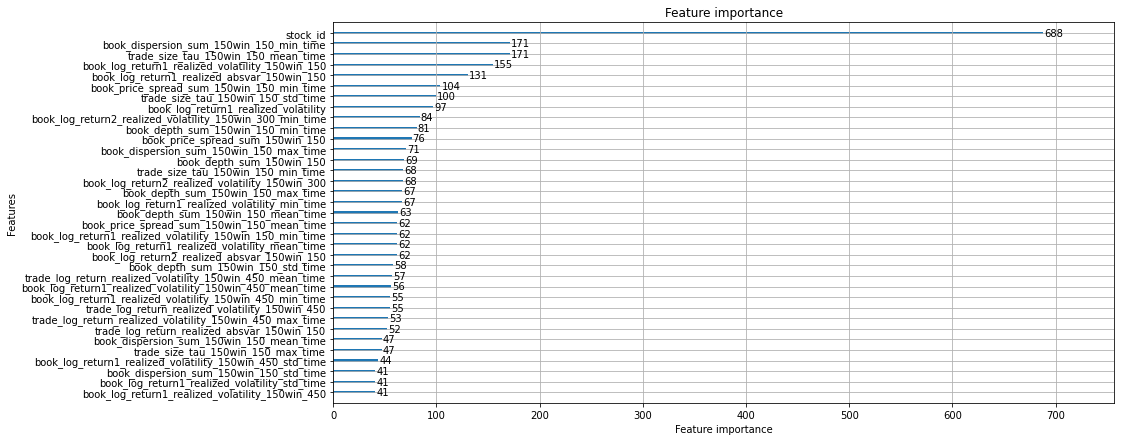

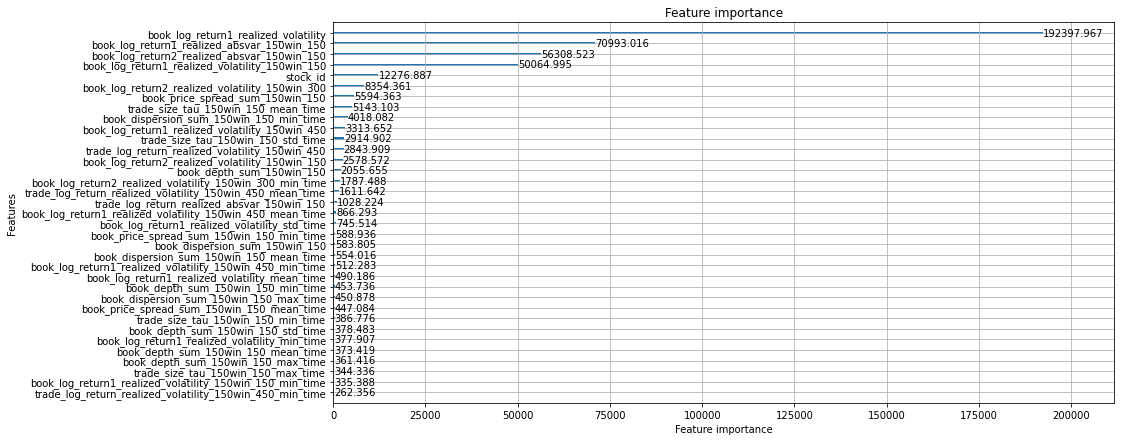

In [10]:
seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 4,
    'num_leaves': 15,
    'min_data_in_leaf': 250,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'feature_fraction': 0.8,
    'categorical_column': [0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

def train_and_evaluate_lgb(train, test, params, try_seed=seed0):
    # Hyperparammeters (just basic)

    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kf = 5
    # Iterate through each fold
    skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                                  groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=try_seed)
    for fold, (trn_ind, val_ind) in enumerate(skf):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        print(x_train.shape)
        print(x_val.shape)
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        tt=test.copy()

        x_train_agg_time, agg_feats_time = get_time_agg(x_train)
        x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
        x_val_agg_time, _ = get_time_agg(x_val)
        x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
        test_agg_time, _ = get_time_agg(tt)
        tt = tt.merge(test_agg_time, how='left', on='time_id')
        del x_train_agg_time,  x_val_agg_time, test_agg_time
        gc.collect()
        
        traincols = features+agg_feats_time
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[traincols], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[traincols], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[traincols])
        # Predict the test set       
        test_predictions += model.predict(tt[traincols]) / kf
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35)
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35, importance_type='gain')
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    # Return test predictions
    return test_predictions

# Traing and evaluate
predictions_lgb_1 = train_and_evaluate_lgb(train, test, params0)

100%|██████████| 3830/3830 [05:53<00:00, 10.82it/s]


Training fold 1
(386039, 18)
(42893, 18)
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000489873	training's RMSPE: 0.226495	valid_1's rmse: 0.00048122	valid_1's RMSPE: 0.224689
[100]	training's rmse: 0.000458222	training's RMSPE: 0.211861	valid_1's rmse: 0.000457576	valid_1's RMSPE: 0.213649
[150]	training's rmse: 0.000448183	training's RMSPE: 0.20722	valid_1's rmse: 0.00045423	valid_1's RMSPE: 0.212087
[200]	training's rmse: 0.000440911	training's RMSPE: 0.203857	valid_1's rmse: 0.000453131	valid_1's RMSPE: 0.211574
[250]	training's rmse: 0.000434823	training's RMSPE: 0.201042	valid_1's rmse: 0.000452219	valid_1's RMSPE: 0.211148
[300]	training's rmse: 0.000429721	training's RMSPE: 0.198684	valid_1's rmse: 0.000451987	valid_1's RMSPE: 0.21104
[350]	training's rmse: 0.000425249	training's RMSPE: 0.196616	valid_1's rmse: 0.000451671	valid_1's RMSPE: 0.210892
Early stopping, best iteration is:
[349]	training's rmse: 0.000425354	training's RMSPE: 0.1

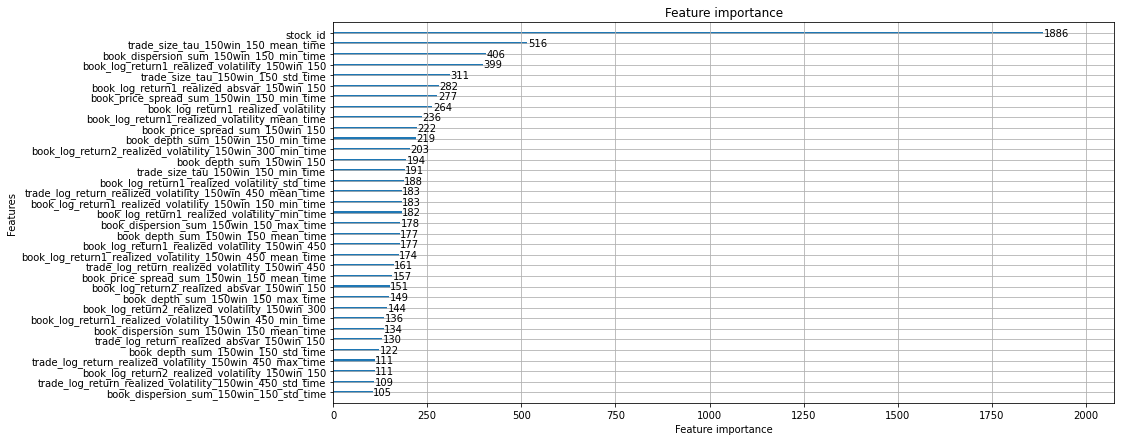

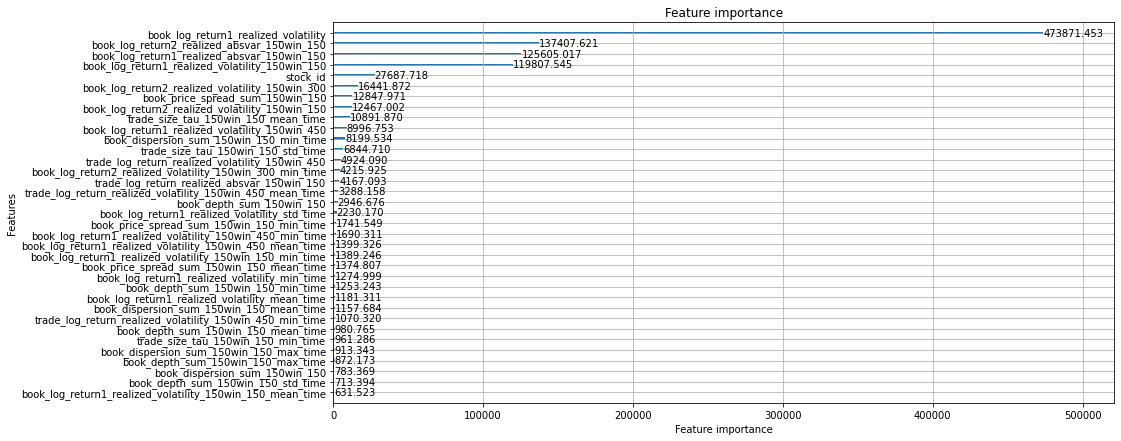

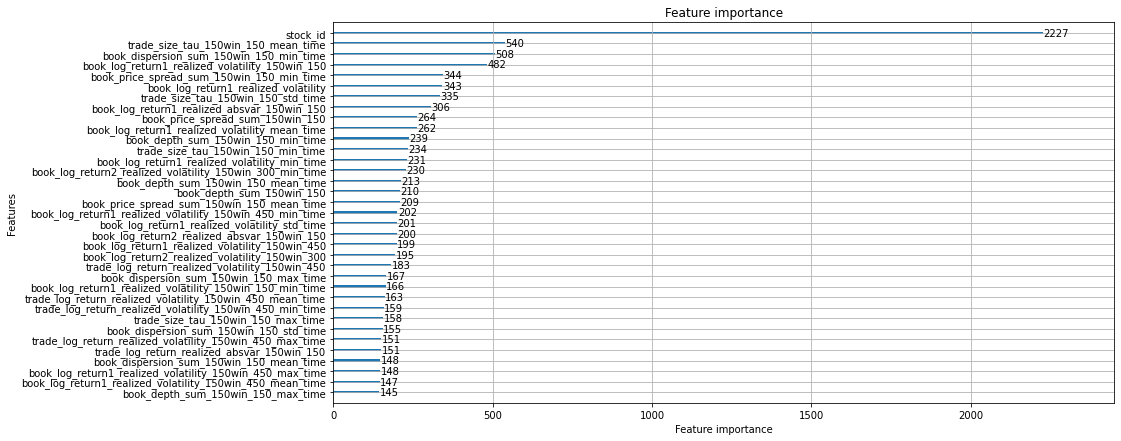

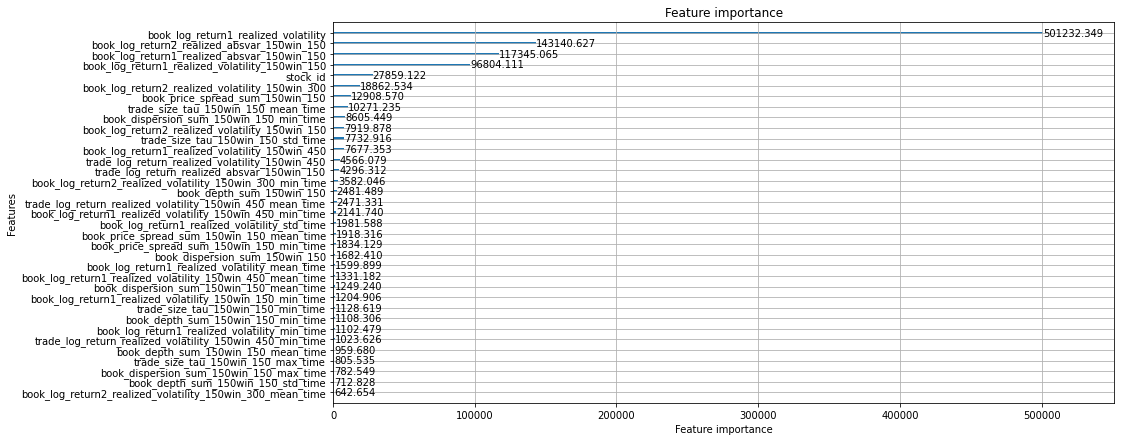

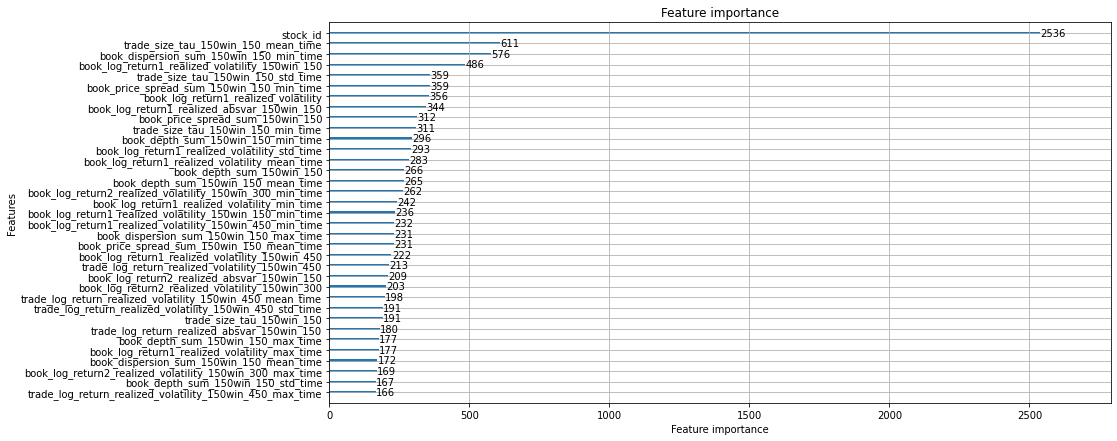

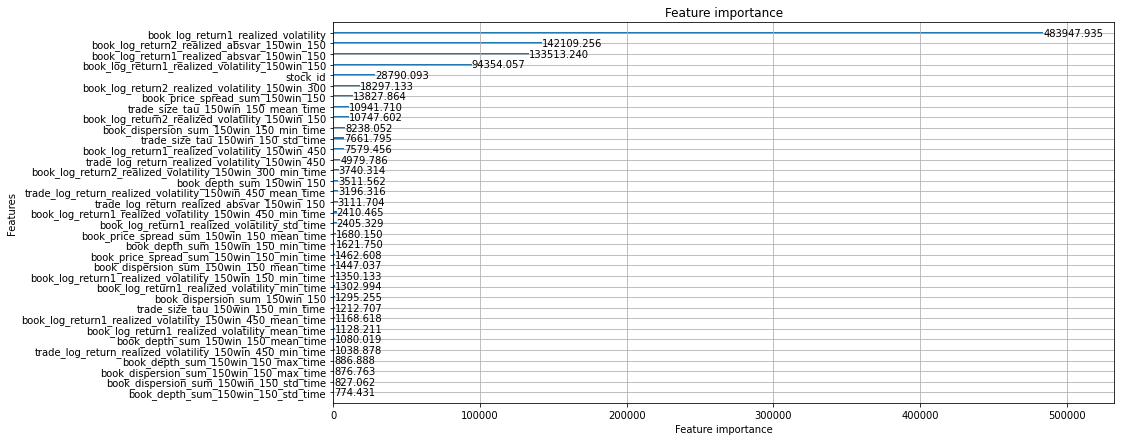

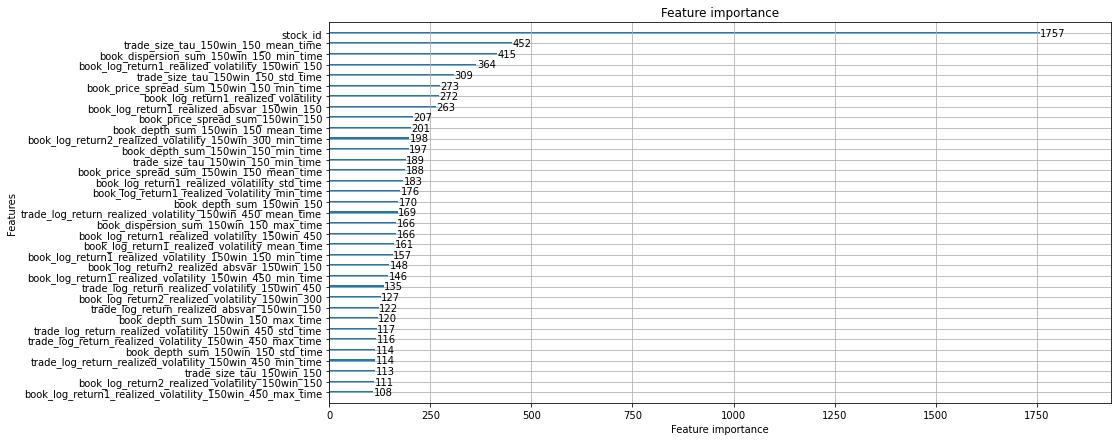

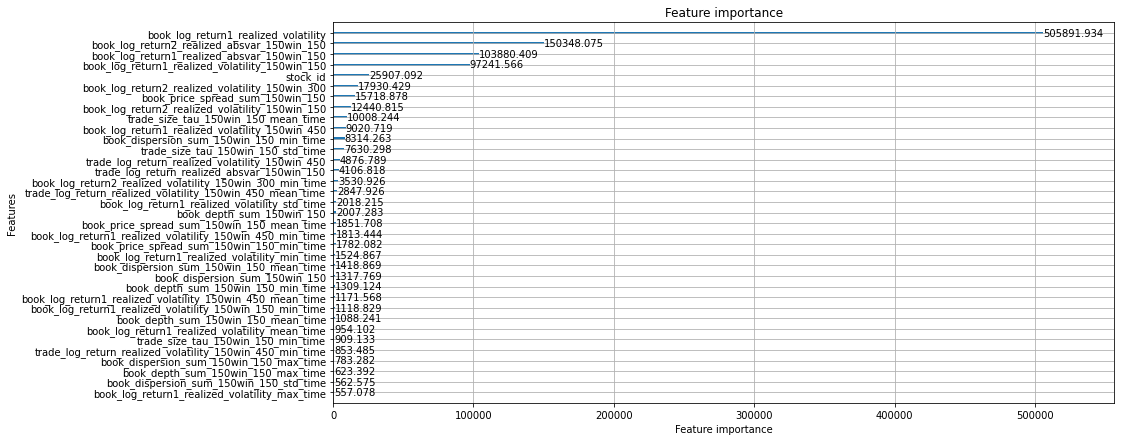

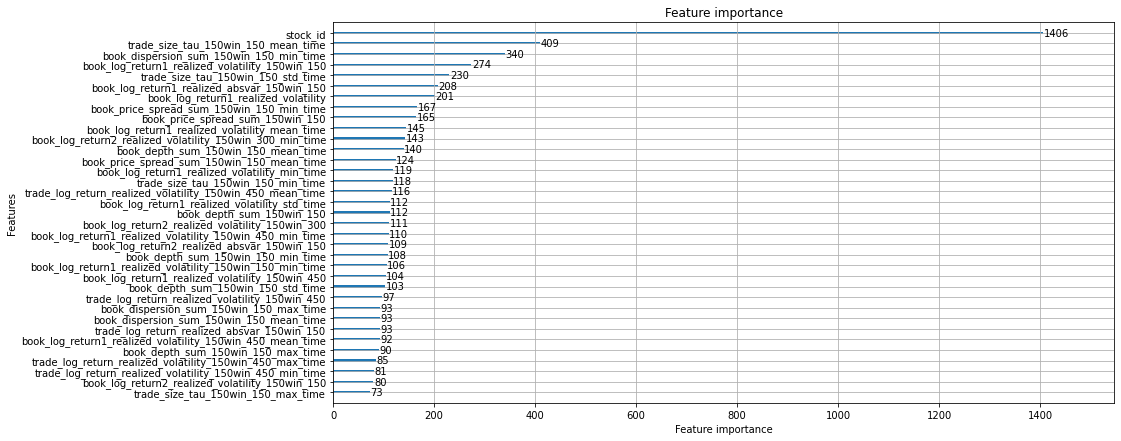

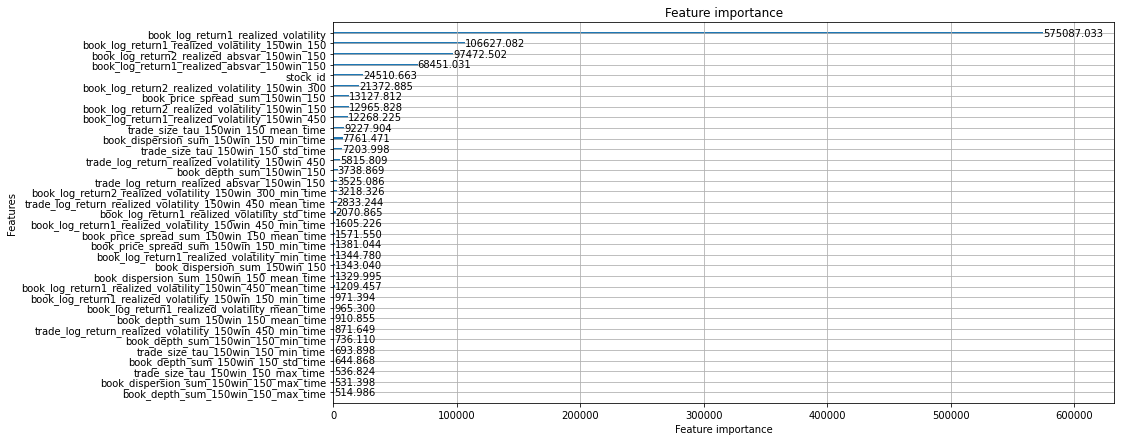

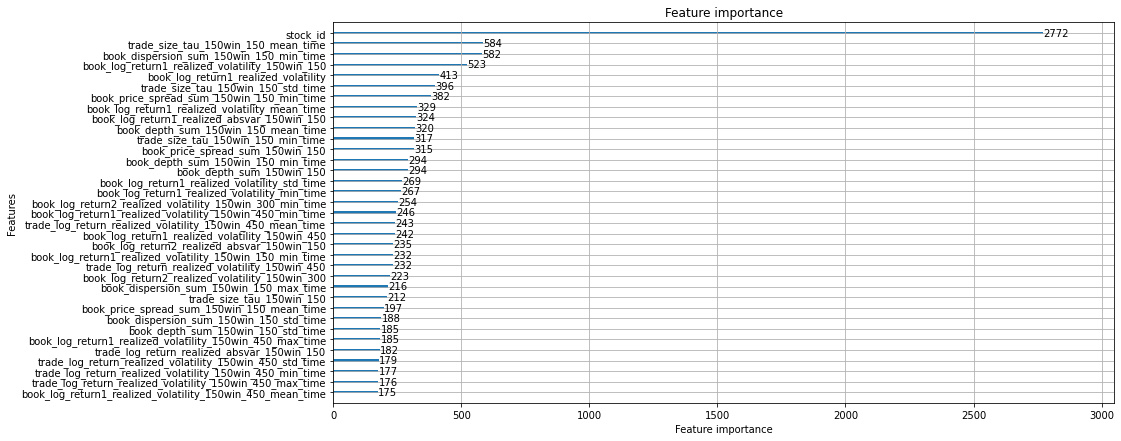

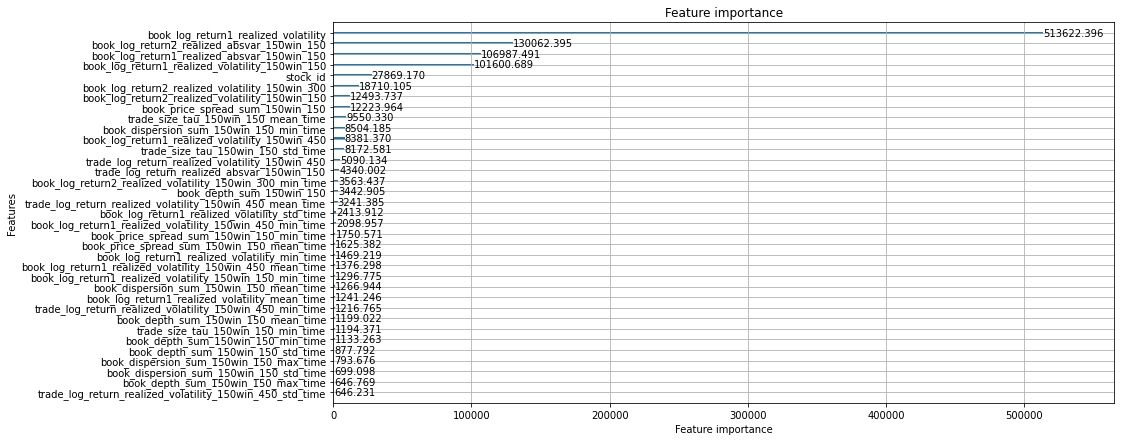

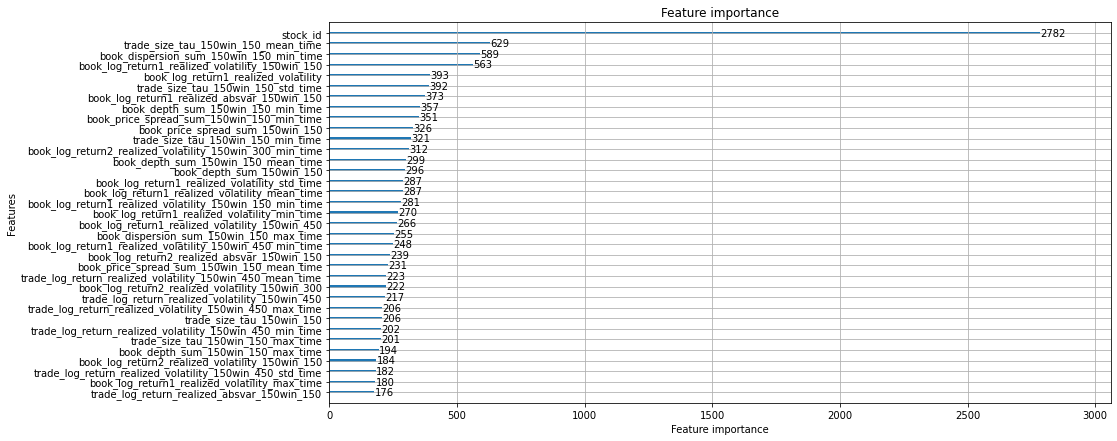

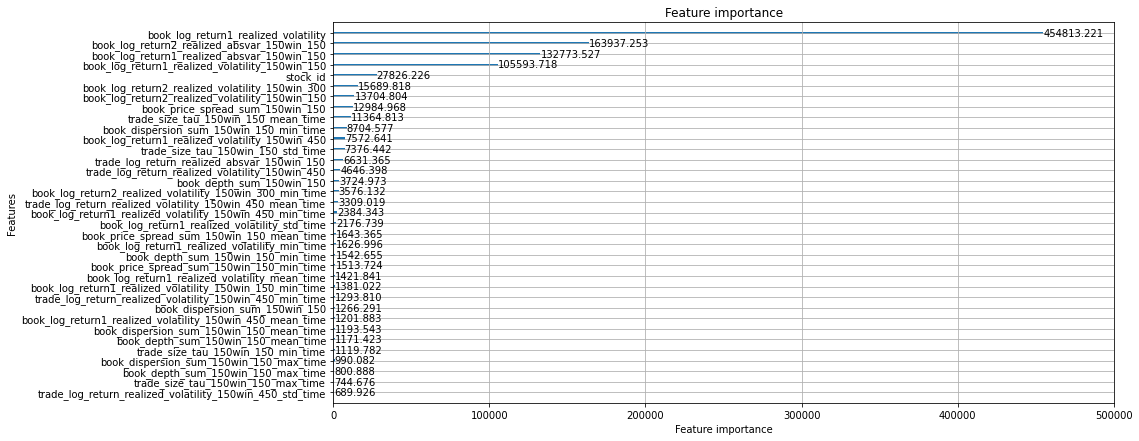

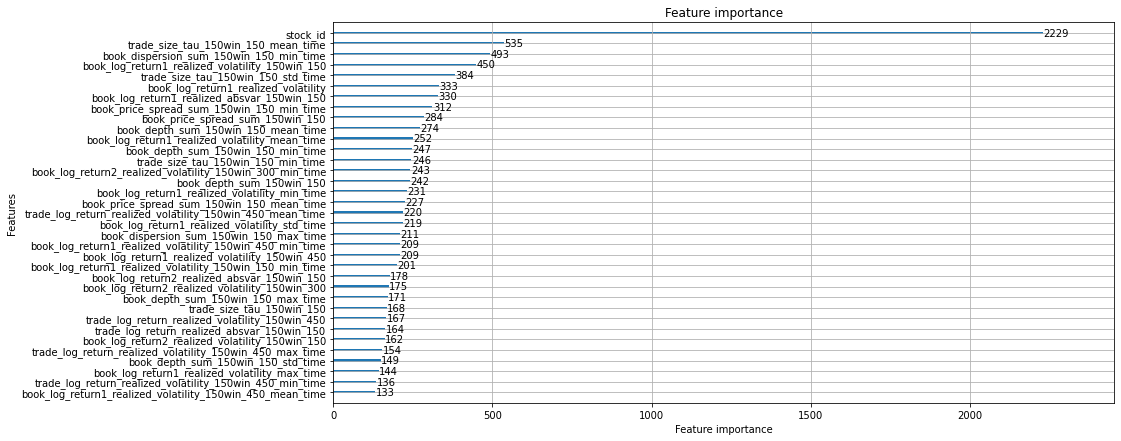

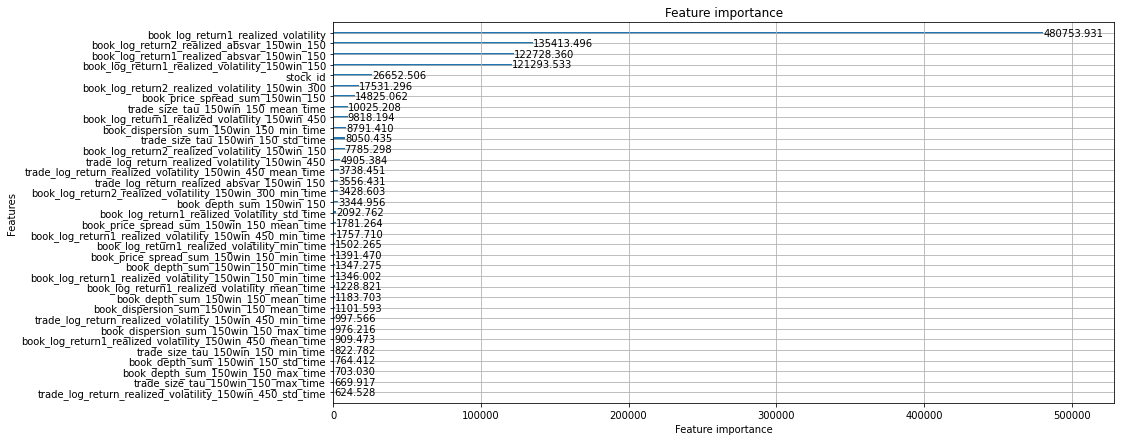

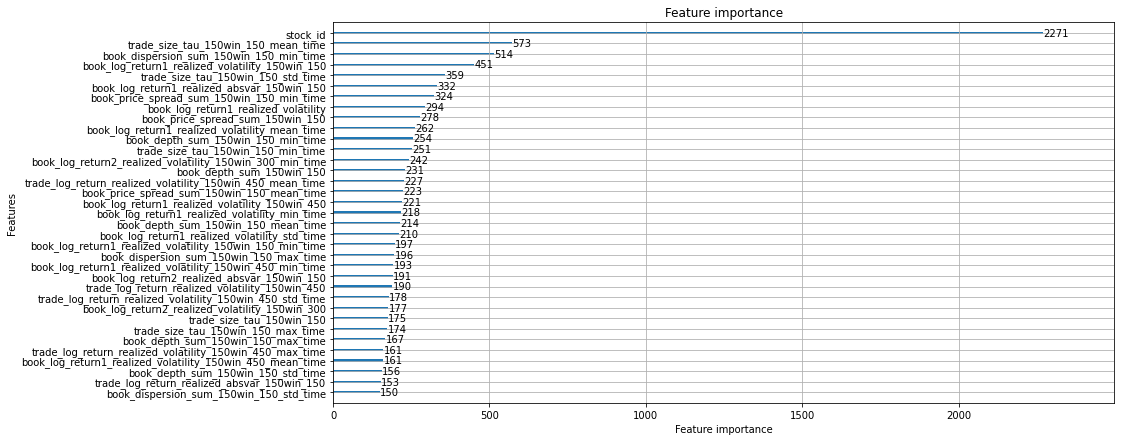

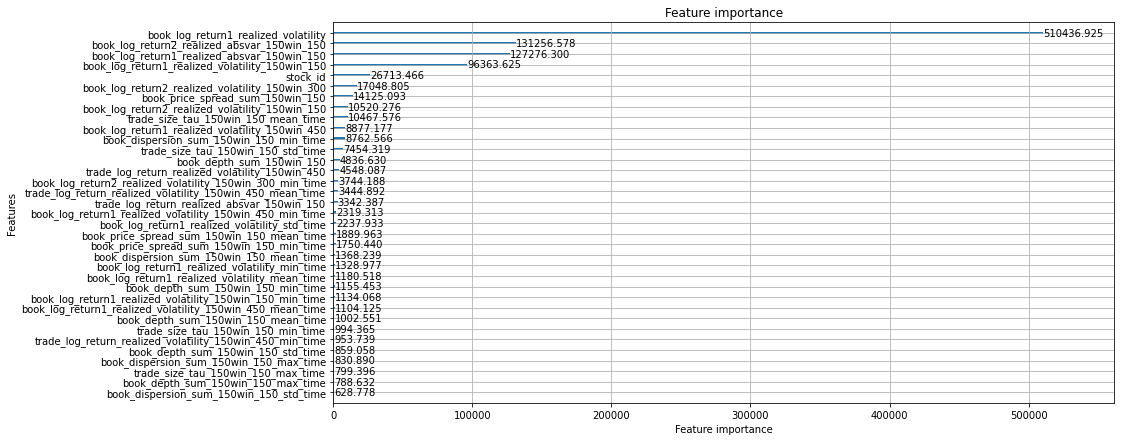

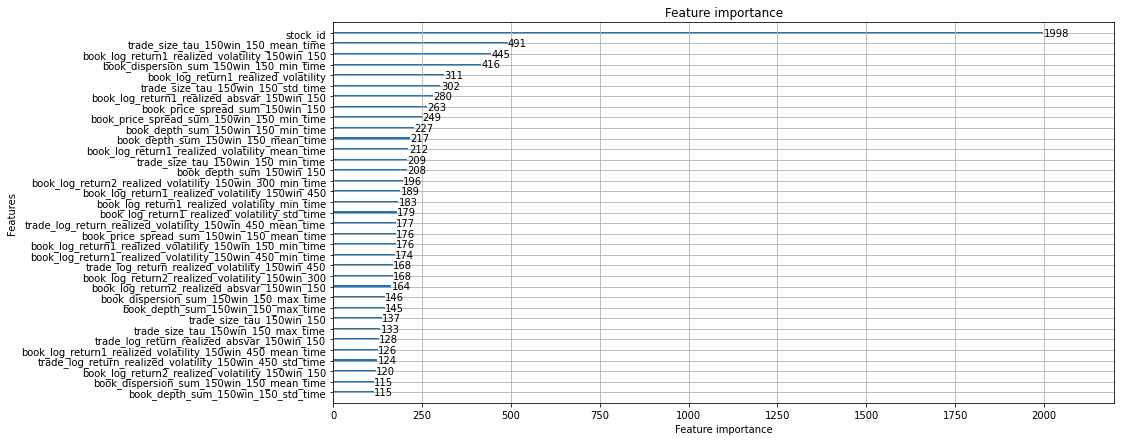

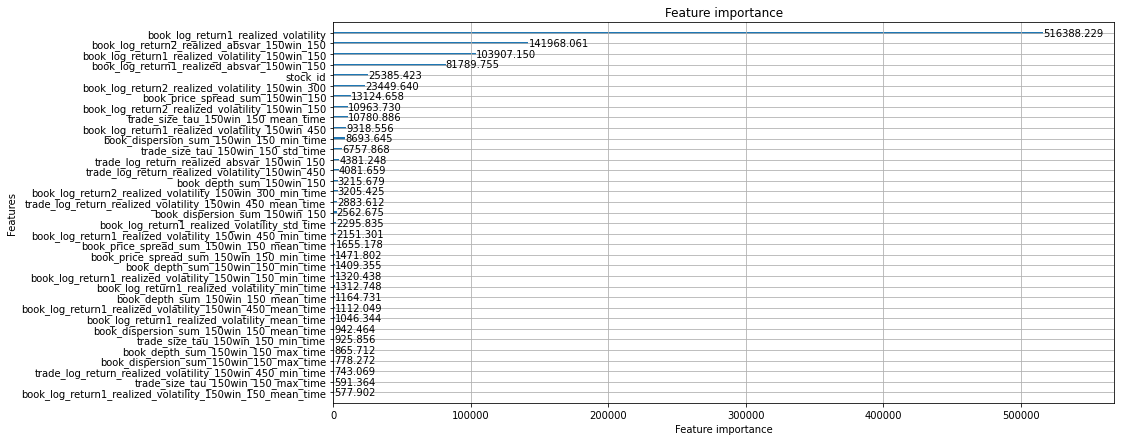

In [11]:
seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'num_leaves': 31,
    'min_data_in_leaf': 100,
    'learning_rate': 0.05,
    'subsample': 0.95,
    'subsample_freq': 1,
    'feature_fraction': 0.9,
    'categorical_column': [0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

def train_and_evaluate_lgb(train, test, params, try_seed=seed0):
    # Hyperparammeters (just basic)

    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kf = 10
    # Iterate through each fold
    skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                                  groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=try_seed)
    for fold, (trn_ind, val_ind) in enumerate(skf):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        print(x_train.shape)
        print(x_val.shape)
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        tt=test.copy()

        x_train_agg_time, agg_feats_time = get_time_agg(x_train)
        x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
        x_val_agg_time, _ = get_time_agg(x_val)
        x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
        test_agg_time, _ = get_time_agg(tt)
        tt = tt.merge(test_agg_time, how='left', on='time_id')
        del x_train_agg_time,  x_val_agg_time, test_agg_time
        gc.collect()
        
        traincols = features+agg_feats_time
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[traincols], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[traincols], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[traincols])
        # Predict the test set       
        test_predictions += model.predict(tt[traincols]) / kf
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35)
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35, importance_type='gain')
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    # Return test predictions
    return test_predictions

# Traing and evaluate
predictions_lgb_2 = train_and_evaluate_lgb(train, test, params0)

In [12]:
from numpy.random import seed
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from tensorflow import keras
import numpy as np
from keras import backend as K
from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))

In [13]:
def base_model(numfeats, cat_data=train['stock_id']):
    
    hidden_units = (64, 32, 32, 16, 16, 16, 16, 8, 8)
    stock_embedding_size = 24
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(numfeats,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='swish')(out)

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

tf.random.set_seed(42)
seed(42)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0,
                                      mode='min', restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, 
                                               verbose=0, mode='min')

scores_folds = {}
model_name = 'NN'

scores_folds[model_name] = []
counter = 1

predictions_nn_1 = np.zeros(test.shape[0])
y = train['target']
# Create a KFold object
kf = 5
# Iterate through each fold
features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                              groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=2021)
for fold, (trn_ind, val_ind) in enumerate(skf):
    print(f'Training fold {fold + 1}')
    
    x_train = train.iloc[trn_ind].copy()
    x_val = train.iloc[val_ind].copy()
    print(x_train.shape)
    print(x_val.shape)
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    tt = test.copy()
    
    #############################################################################################
    # NN
    #############################################################################################
    
    x_train.loc[:, feats_nostock] = x_train.loc[:, feats_nostock].fillna(x_train.groupby('stock_id')[feats_nostock].transform('median')).values
    for i in x_val.stock_id.unique():
        x_val.loc[x_val.stock_id==i, feats_nostock] = x_val.loc[x_val.stock_id==i, feats_nostock].fillna(x_train.loc[x_train.stock_id==i, feats_nostock].median()).values
    for i in tt.stock_id.unique():
        tt.loc[tt.stock_id==i, feats_nostock] = tt.loc[tt.stock_id==i, feats_nostock].fillna(x_train.loc[x_train.stock_id==i, feats_nostock].median()).values
    
    x_train_agg_time, agg_feats_time = get_time_agg(x_train)
    x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
    x_val_agg_time, _ = get_time_agg(x_val)
    x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
    test_agg_time, _ = get_time_agg(tt)
    tt = tt.merge(test_agg_time, how='left', on='time_id')
    del x_train_agg_time,  x_val_agg_time, test_agg_time
    gc.collect()

    traincols = feats_nostock+agg_feats_time

    for i in tt.stock_id.unique():
        tt.loc[tt.stock_id==i, traincols] = tt.loc[tt.stock_id==i, traincols].fillna(x_train.loc[x_train.stock_id==i, traincols].median()).values

    num_trans = Pipeline([('qt', QuantileTransformer(n_quantiles=2000, output_distribution='normal')),
                         ('numscaler', MinMaxScaler())])
    agg_trans = Pipeline([('aggscaler', MinMaxScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', num_trans, feats_nostock),
                                                    ('agg', agg_trans, agg_feats_time)])
    pipe = Pipeline([('pp', preprocessor)])
    pipe.fit(x_train[traincols])
    
    model = base_model(len(traincols))
    model.compile(
        keras.optimizers.Adam(learning_rate=0.001),
        loss=root_mean_squared_per_error
    )
    
    model.fit([x_train['stock_id'], pipe.transform(x_train[traincols])], 
              y_train,               
              batch_size=2048,
              epochs=1000,
              validation_data=([x_val['stock_id'], pipe.transform(x_val[traincols])], y_val),
              callbacks=[es, plateau],
              validation_batch_size=len(y_val),
              shuffle=True,
              verbose = 1)

    preds = model.predict([x_val['stock_id'], pipe.transform(x_val[traincols])]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_val, y_pred = preds), 5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    predictions_nn_1 += model.predict([tt['stock_id'], pipe.transform(tt[traincols])]).reshape(1,-1)[0].clip(0,1e10) / kf

    counter += 1
    
print('RMSPE {}: Folds: {}'.format(model_name, scores_folds[model_name]))

100%|██████████| 3830/3830 [02:09<00:00, 29.64it/s]


Training fold 1
(343146, 18)
(85786, 18)
Epoch 1/1000
168/168 [==============================] - 4s 14ms/step - loss: 0.5663 - val_loss: 0.2747
Epoch 2/1000
168/168 [==============================] - 1s 9ms/step - loss: 0.2538 - val_loss: 0.2789
Epoch 3/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.2490 - val_loss: 0.2366
Epoch 4/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.2561 - val_loss: 0.2370
Epoch 5/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.2633 - val_loss: 0.2325
Epoch 6/1000
168/168 [==============================] - 1s 9ms/step - loss: 0.2405 - val_loss: 0.2475
Epoch 7/1000
168/168 [==============================] - 1s 9ms/step - loss: 0.2404 - val_loss: 0.2416
Epoch 8/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.2511 - val_loss: 0.2313
Epoch 9/1000
168/168 [==============================] - 2s 9ms/step - loss: 0.2414 - val_loss: 0.2381
Epoch 10/1000
168/168 [=================

In [14]:
test['target'] = predictions_nn_1*0.6 + predictions_lgb_1*0.2 + predictions_lgb_2*0.2

display(test[['row_id', 'target']].head(3))
test[['row_id', 'target']].to_csv('submission.csv',index = False)

row_id    target
0    0-4  0.002707
1   0-32  0.003448
2   0-34  0.003448